# Segmentation problem C.1 - segmenting bottles

## 1) Load packages

We start by loading a standard set of Python libraries, and install and load [keras_unet](https://github.com/karolzak/keras-unet), a package for image segmentation tasks with a number of useful helper functions.

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras_unet

2024-05-07 19:08:11.325901: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-07 19:08:11.378834: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 19:08:11.378876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 19:08:11.380168: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-07 19:08:11.390696: I tensorflow/core/platform/cpu_feature_guar

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


## 2) Load data for segmentation model

In [2]:
# Retrieve directory where we will get save processed data and features
parent_directory = os.path.abspath('../')

# Directory for saved features
features_path = os.path.join(parent_directory,'data/features')
os.makedirs(features_path, exist_ok=True)

# Directory for saved models
saved_models_path = os.path.join(parent_directory,'saved_models')
os.makedirs(saved_models_path, exist_ok=True)

Next, we load the images and masks for the images of bottles we set aside in notebooks 1 and 2.

We use the images created with **widen_param=0.2**, meaning that our objects will be in the **center of the image** but we retain some of the **image background** beyond the annotation bounding box. As a reminder, we also restricted the sample to images with **only one bottle**. Therefore, the model will not encounter any images containing two or more objects to segment.


In [3]:
# Load the processed (cropped+framed) images
with np.load("{}/{}/{}".format(features_path,"widen_param_0.05","classification-images.npz"), allow_pickle=True) as npz_file:
    # It's a dictionary-like object
    print(list(npz_file.keys()))

    # Load the arrays
    s1_images = npz_file["s1"]
    s1_masks = npz_file["s1_masks"]

['c1', 'c2', 's1', 's1_masks']


## 3) Plotting images (X) and masks (Y)

The image masks have the same shape as the corresponding images (224x224 pixels), and each pixel has either a value of 0 (if it's outside of the object) or 1 (if it's inside of the object). A key difference is that our images are in colour (and therefore have three colour channels) whereas the masks only have one colour channel or dimension.

We rescale the images so the value in each image pixel is between 0 and 1, and set set the data type for the masks to integers.

In [4]:
# Pre-process masks and images
s1_masks = s1_masks.astype(np.uint8)
s1_images = s1_images*1./255.

In [5]:
"Shape of images array: {}, Shape of masks array: {}".format(s1_images.shape,s1_masks.shape)

'Shape of images array: (248, 224, 224, 3), Shape of masks array: (248, 224, 224, 1)'

Then we plot 10 images from our set using the plot_imgs function, showing the original image and its mask side by side. We also show the overlay, with the mask on top of the original image. This is a useful sense check, to verify that our images and masks have been processed properly.

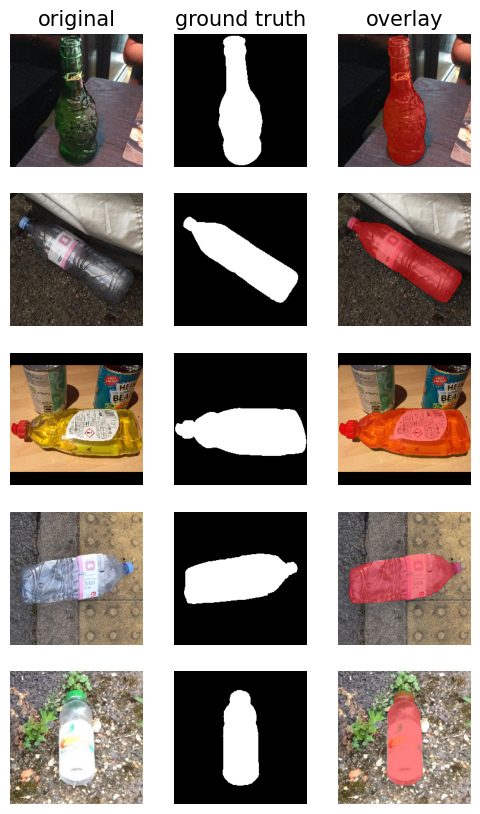

In [6]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=s1_images, mask_imgs=s1_masks, nm_img_to_plot=5, figsize=2)

## 4) Splitting data into train, validation and test sets

In these models, our predictors (X) will be the images and the outcome (Y) will be the image masks. As opposed to our previous classification problems, here we will be making predictions at the _pixel_ level rather than at the image level. Indeed, we are predicting whether each pixel is located inside the bottle (Y=1) or outside the bottle (Y=0).

First, we split the data into two sets: a combined training/validation set (90%) and a test set (10%).

Then, we split the combined training/validation set into training (80%) and validation sets (20%).

The resulting training set has 178 images, the validation set has 45 images and the testing set has 25 images.

In [7]:
# Split out a training/validation set and a test set
from sklearn.model_selection import train_test_split

x_trainval, x_test, y_trainval, y_test = train_test_split(s1_images, s1_masks, test_size=0.1, random_state=8)

print("x_test: {}, y_test: {}".format(x_test.shape,y_test.shape))

x_test: (25, 224, 224, 3), y_test: (25, 224, 224, 1)


In [8]:
# Further split out the training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.2, random_state=8)

print("x_train: {}, y_train: {}".format(x_train.shape,y_train.shape))
print("x_val: {}, y_val: {}".format(x_val.shape,y_val.shape))

del x_trainval
del y_trainval

x_train: (178, 224, 224, 3), y_train: (178, 224, 224, 1)
x_val: (45, 224, 224, 3), y_val: (45, 224, 224, 1)


## 5) Setting up a convolutional neural network for image segmentation

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model

 for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; donesudo echo 0 | sudo tee -a /sys/bus/pci/devices/0000\:01\:00.0/numa_nodeWe specify a convolutional neural network with a U-net architecture for our segmentation task. The code to specify the model architecture was found in a [tutorial](https://www.machinelearningnuggets.com/image-segmentation-with-u-net-define-u-net-model-from-scratch-in-keras-and-tensorflow/) on image segmentation using Keras written by Derrick Mwiti.

First, the model receives an input image of size 224x224x3, representing the three colour channels.

Then, there is a contraction path which involves downsampling the input image and extracting increasingly abstract features. The number of filters in each block goes from 16 to 256. Between each block, a Max Pooling operation with stride 2 reduces the spatial resolution by half.

Traditional convolutional neural networks with pooling layers and dense layers are not suitable for image segmentation tasks because they discard **spatial information**, which is important to identify *where* objects are located in an image. U-Net models, however, are designed to preserve spatial information by upsampling the image, which enables the model to capture *where* objects might be located.

Following the contraction path, the expansive path involves upsampling the features back to the original image size using transposed convolutions. Finally, a sigmoid activation function generates the binary segmentation mask.

In [10]:
### Inputs ###

inputs = tf.keras.layers.Input((224, 224, 3))

### Contraction path ###

  #16 filters#
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

  #32 filters#
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)

  #64 filters#
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)

  #128 filters#
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)

  #256 filters#
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(b5)
c5 = tf.keras.layers.Dropout(0.3)(r5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

### Expansive path ###

  #128 filters#
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
u6 = tf.keras.layers.BatchNormalization()(u6)
u6 = tf.keras.layers.ReLU()(u6)

  #64 filters#
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tf.keras.layers.concatenate([u7, c3])
u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)

  #32 filters#
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tf.keras.layers.concatenate([u8, c2])
u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)

  #16 filters#
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)

### Outputs ###

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(u9)

2024-05-07 19:08:14.794640: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-07 19:08:14.831182: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-07 19:08:14.831443: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [11]:
unet_model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

## 6) Data augmentation

We will use the 'get_augmented' function from the keras_unet package to artificially augment our training data. By generating "new" images, data augmentation can improve the model's performance and generalizability. This helps the model learn more robust representations of the data and reduce overfitting.

In [12]:
# Create an augmented images generator for the training set
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train,
    batch_size=3,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    ))

Our augmented images generator output three images at a time, and we plot a sample of those augmented images to check that the spatial relationships in the masks have been preserved.

(3, 224, 224, 3) (3, 224, 224, 1)


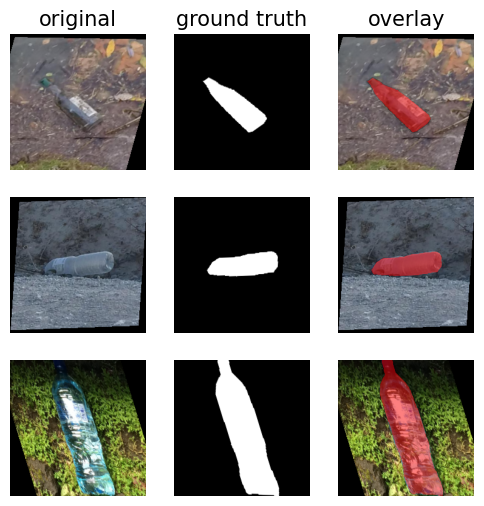

In [13]:
# Plot a sample of augmented training images
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=3, figsize=2)

## 7) Fitting our model

### The IOU metric

The intersection-over-union (IoU) metric is a widely used metric to assess the performance of an image segmentation model. It measures the overlap between the predicted segmentation mask and the ground truth mask for an image. IoU ranges from 0 to 1, with 0 meaning no overlap and 1 meaning a perfect overlap.

![iou](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2016/09/iou_examples.png?lossy=2&strip=1&webp=1)

*Adrian Rosebrock, "Intersection over union for object detection" ([link](https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/))*

### Compiling and fitting the model

In [14]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras_unet.metrics import iou, iou_thresholded

Using a model checkpoint, we will save the model weights each time the thresholded IOU improves on the validation set images.

In [15]:
# Create a checkpoint for our U-net model
model_path = "{}/{}/{}".format(saved_models_path,"widen_param_0.05","segm_model.h5")

callback_checkpoint = ModelCheckpoint(
    model_path,
    verbose=1,
    monitor='val_iou_thresholded',
    mode='max',
    save_best_only=True,
)

We will use a binary cross-entropy loss function, since this is a pixel-level binary classification problem.

Our data generator provides the model with training data in batches, with each batch consisting of three input images and masks. Our generator provides 300 batches per epoch, and the model is trained for 50 epochs. As a reminder, there are 178 images in the training set, so each epoch will see at least one version of each image. This allows the model to slowly improve its performance over 50 iterations.

In [16]:
# Compile model
unet_model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

We set a random seed for maximum reproducibility.

In [17]:
# Set seed
tf.keras.utils.set_random_seed(1)

Finally, we fit our convolutional neural network with a U-net architecture.

In [18]:
# Fit model
history = unet_model.fit(
    train_gen,
    steps_per_epoch=300,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=[callback_checkpoint],
    verbose=2
)

Epoch 1/50


2024-05-07 19:08:21.260292: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-07 19:08:21.885327: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-07 19:08:24.010759: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f67104b2660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-07 19:08:24.010804: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-05-07 19:08:24.017150: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715108904.094288    8861 device_compiler.h:186] Compiled cluster using XLA!  This line is log


Epoch 1: val_iou_thresholded improved from -inf to 0.30298, saving model to /home/jovyan/workspace/taco-image-analysis/saved_models/widen_param_0.05/segm_model.h5
300/300 - 26s - loss: 0.3529 - iou: 0.3273 - iou_thresholded: 0.4590 - val_loss: 0.3589 - val_iou: 0.2650 - val_iou_thresholded: 0.3030 - 26s/epoch - 86ms/step
Epoch 2/50


/opt/saturncloud/envs/saturn/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_iou_thresholded improved from 0.30298 to 0.54912, saving model to /home/jovyan/workspace/taco-image-analysis/saved_models/widen_param_0.05/segm_model.h5
300/300 - 11s - loss: 0.2621 - iou: 0.4405 - iou_thresholded: 0.5676 - val_loss: 0.2571 - val_iou: 0.4113 - val_iou_thresholded: 0.5491 - 11s/epoch - 37ms/step
Epoch 3/50

Epoch 3: val_iou_thresholded improved from 0.54912 to 0.55761, saving model to /home/jovyan/workspace/taco-image-analysis/saved_models/widen_param_0.05/segm_model.h5
300/300 - 11s - loss: 0.2347 - iou: 0.4891 - iou_thresholded: 0.6055 - val_loss: 0.2457 - val_iou: 0.4556 - val_iou_thresholded: 0.5576 - 11s/epoch - 37ms/step
Epoch 4/50

Epoch 4: val_iou_thresholded improved from 0.55761 to 0.57405, saving model to /home/jovyan/workspace/taco-image-analysis/saved_models/widen_param_0.05/segm_model.h5
300/300 - 11s - loss: 0.2104 - iou: 0.5263 - iou_thresholded: 0.6481 - val_loss: 0.2347 - val_iou: 0.4828 - val_iou_thresholded: 0.5741 - 11s/epoch - 37ms/st

In [19]:
# Path to save model history
history_path = "{}/{}/{}".format(saved_models_path,"widen_param_0.05","segm_model_history.csv")

# Save model history
with open(history_path, mode='w') as f:
    pd.DataFrame(history.history).to_csv(f)

By the 150th epoch, the highest thresholded IOU achieved on the validation set is close to **64%**.

With an increasing number of epochs, we can see that the training loss keeps decreasing while the validation loss hovers at around the same level (loss=0.15). Our training IOU metric also keeps increasing, which shows that the model is learning weights that almost perfectly segment the bottles in the training set. The thresholded IOU on the validations set, however, has stopped increasing after about 50 epochs, a sign of overfitting.



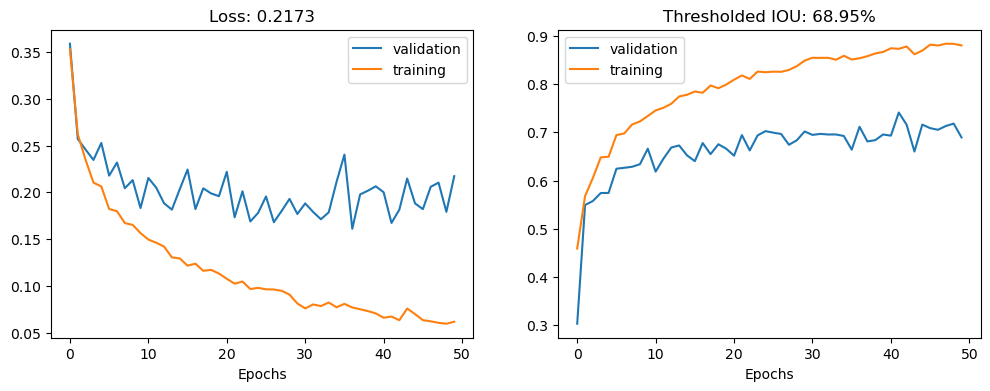

In [20]:
# Plot the training and validation curves
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Loss function
ax1.set_title("Loss: {:.4f}".format(history.history["val_loss"][-1]))
ax1.plot(history.history["val_loss"], label="validation")
ax1.plot(history.history["loss"], label="training")
ax1.set_xlabel("Epochs")
ax1.legend()

# IOU
ax2.set_title("Thresholded IOU: {:.2f}%".format(history.history["val_iou_thresholded"][-1] * 100))
ax2.plot(history.history["val_iou_thresholded"], label="validation")
ax2.plot(history.history["iou_thresholded"], label="training")
ax2.set_xlabel("Epochs")
ax2.legend()

# Plot
plt.show()

## 8) Assessing performance on the test set

Finally, we can segment the images in our test set using the model we just trained.

In [21]:
# Load weights from saved model
unet_model.load_weights(model_path)

In [22]:
# Generate predictions on the held-out test set
y_pred = unet_model.predict(x_test)

1/1 [==============================] - 2s 2s/step


In order to use the use the 'iou_thresholded' function, we need to convert both the masks and the prediction arrays into floats. We then proceed to predict the thresholded IOUs for the 25 images in the test set.

In [23]:
# Format predictions
y_pred = y_pred.astype(np.float32) #y_pred are the predicted image masks on the testing set
y_test_float = y_test.astype(np.float32) #y_test are the ground truth masks aside for the testing set

In [24]:
# Compute IOU for test set images
test_set_thresholded_ious = [iou_thresholded(y_true=x,y_pred=y).numpy() for x, y in zip(y_test_float,y_pred)]

In [25]:
pd.Series(test_set_thresholded_ious).describe()

count    25.000000
mean      0.784292
std       0.196197
min       0.308074
25%       0.768635
50%       0.837857
75%       0.928517
max       0.963673
dtype: float64

The thresholded IOUs have a wide range.

In [31]:
lowest_iou = pd.Series(test_set_thresholded_ious).idxmin()

print("The lowest IOU in the test set is {:.2f}".format(test_set_thresholded_ious[lowest_iou]))

The lowest IOU in the test set is 0.31


We can see that, in the case of the worst prediction, the contour of the bottle is difficult to make out against the object background.

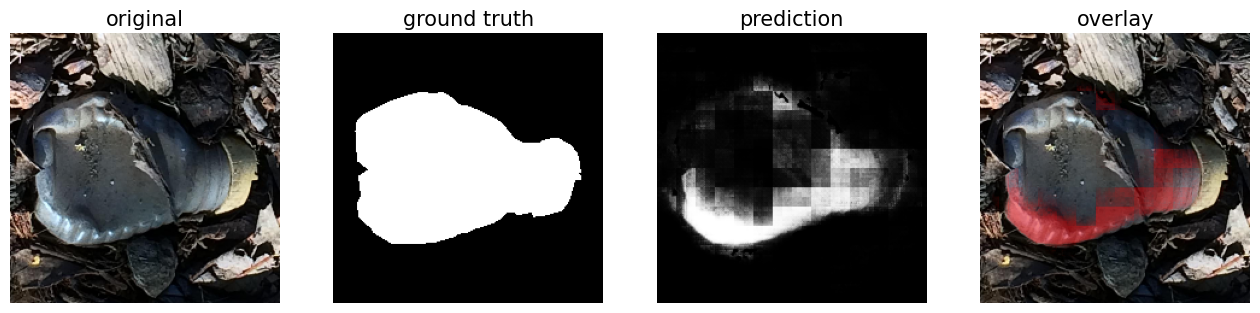

In [27]:
plot_imgs(org_imgs=np.expand_dims(x_test[lowest_iou,:,:,:],axis=0),
          mask_imgs=np.expand_dims(y_test[lowest_iou,:,:,:],axis=0),
          pred_imgs=np.expand_dims(y_pred[lowest_iou,:,:,:],axis=0), nm_img_to_plot=1)

In [28]:
highest_iou = pd.Series(test_set_thresholded_ious).idxmax()

print("The highest IOU in the test set is {:.2f}".format(test_set_thresholded_ious[highest_iou]))

The highest IOU in the test set is 0.96


In contrast, the image with the highest IOU is a much 'cleaner' image where the contours of the bottle are clearly discernible and there are no background elements which might lead pixels to being misclassified.

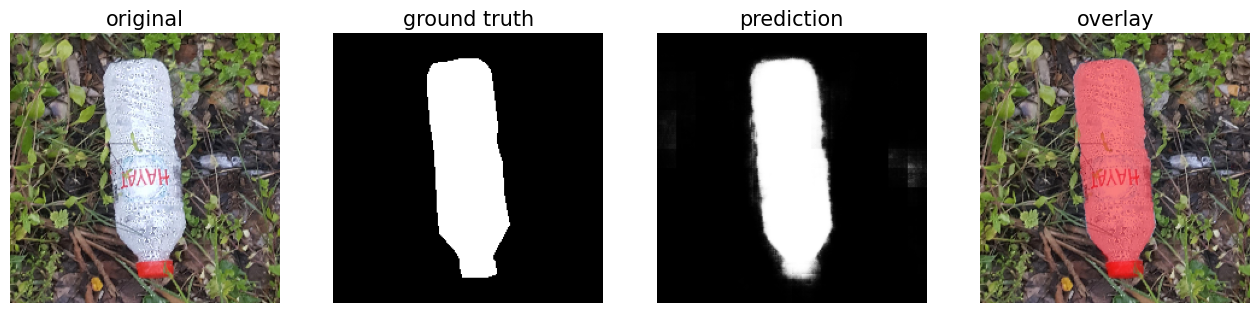

In [29]:
plot_imgs(org_imgs=np.expand_dims(x_test[highest_iou,:,:,:],axis=0),
          mask_imgs=np.expand_dims(y_test[highest_iou,:,:,:],axis=0),
          pred_imgs=np.expand_dims(y_pred[highest_iou,:,:,:],axis=0), nm_img_to_plot=1)

In [30]:
# To summarise the three analyses carried out in this capstone project:

# * We have developed a machine learning model based on logistic regression that correctly **classifies** 76% of images belonging to one of **five classes**: plastic film, carton, bottles, cans and cups. Moreover, if this model predicts that an object is a bottle, there is an 87% likelihood that this is true.

# * Having collected and sorted through our objects to pick out the real bottles (for example, discarding any cups wrongly classified as bottles), we can use our second machine learning model to **classify the material** of the bottle (either glass or plastic). This second model will accurately classify 86% of the bottles we have set aside.

# * Finally, we have also developed a model that could help us (or a recycling robot) identify exactly where the bottles are located in a picture (or the robot's visual field). This is a process called object **segmentation**. This neural network's prediction is measured using the 'intersection over union' metric, which can range from 0 (no overlap) to 1 (perfect overlap). On images of bottles captured relatively close-up, our model achieves a high score of about 0.7.